# Iterative Least-Likely Class Method

Functions used:

`attack_ILLM`

`visualize_attack_ILLM`

`single_attack_stats_ILLM`

`all_samples_attack_ILLM`

`confidence_range_attack_ILLM`

`analyze_attack_ILLM`


These functions are aleady implemented!

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

from modules.illm import*

## 0. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval();

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 1. Introduction

Values for the hyper parameters given in [1]:

- $\alpha = \frac{1}{255}$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

Number of iterations: 20
			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			shower curtain
Confidence: 		99.99%				1.57%



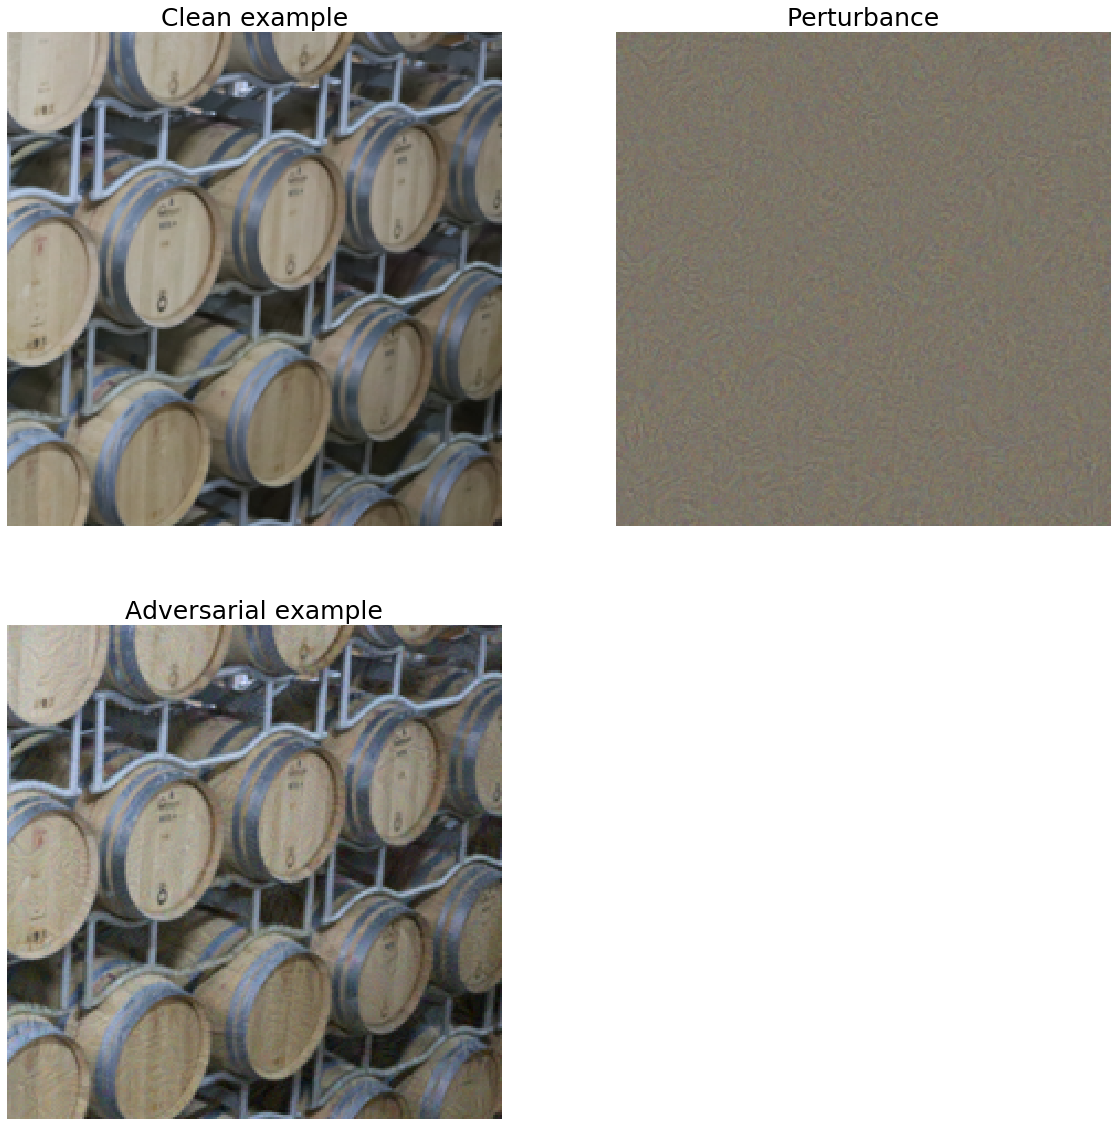

In [4]:
sample = 766
alpha = 1/255
epsilon = 16/255

visualize_attack_ILLM(data_loader, mean, std, model, predict, epsilon, alpha, sample, summarize_attack,folder=None)

Number of iterations: 20
			Clean image	 Adversarial image

Actual class: 		bagel, beigel			bagel, beigel
Predicted class: 	bagel, beigel			mushroom
Confidence: 		44.26%				1.97%



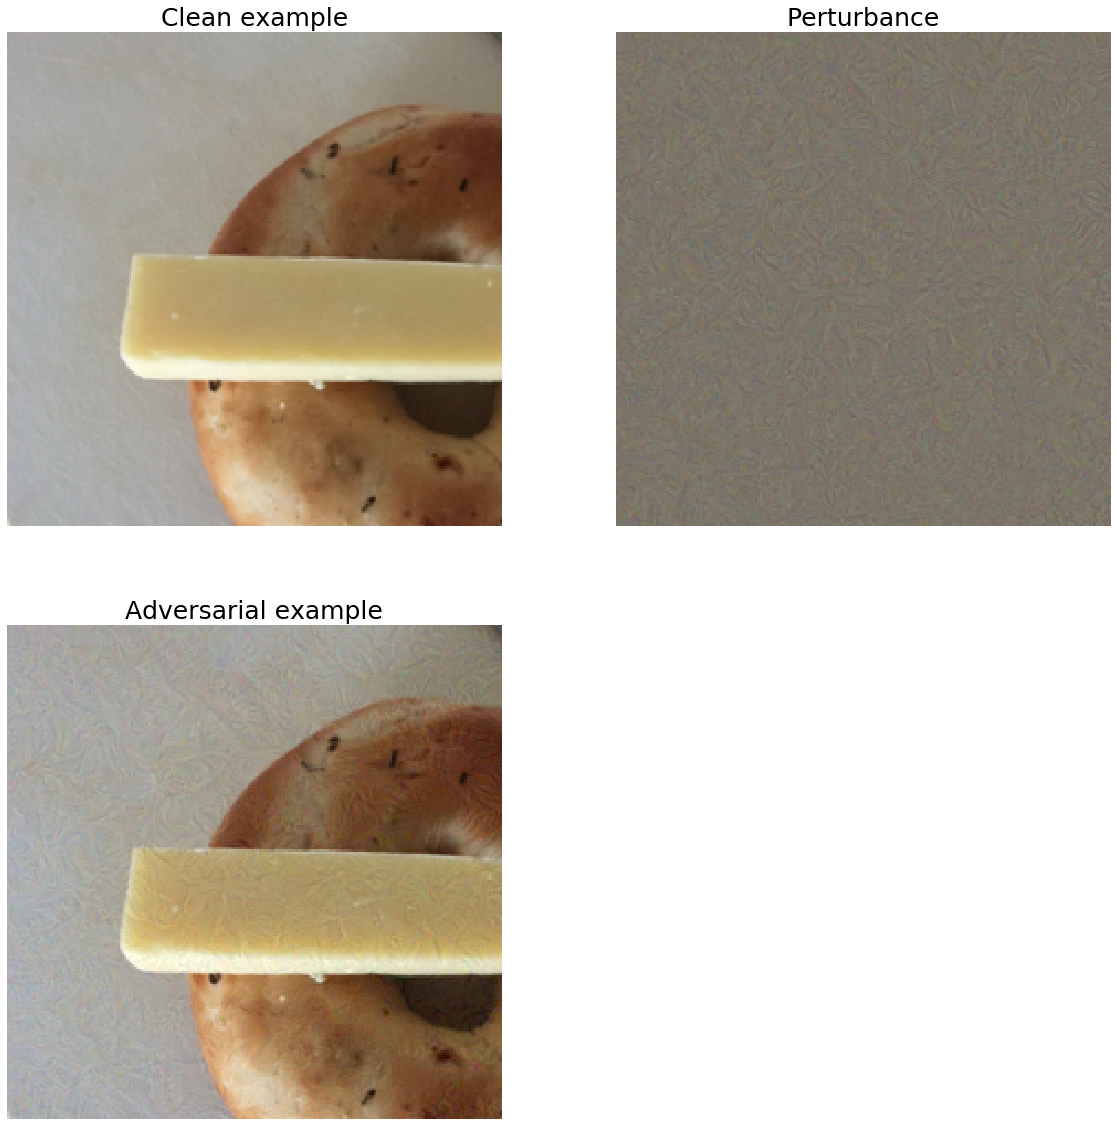

In [5]:
sample = 41

alpha = 1/255
epsilon = 16/255

visualize_attack_ILLM(data_loader, mean, std, model, predict, epsilon, alpha, sample, summarize_attack,folder=None)

## 2. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 2.1 Confidence ranges

In [ ]:
#
max_confidence = 0.60
min_confidence = 0.40

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 0.90
min_confidence = 0.85

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255] 
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 0.95
min_confidence = 0.90

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 0.99
min_confidence = 0.95

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 1.00
min_confidence = 0.99

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

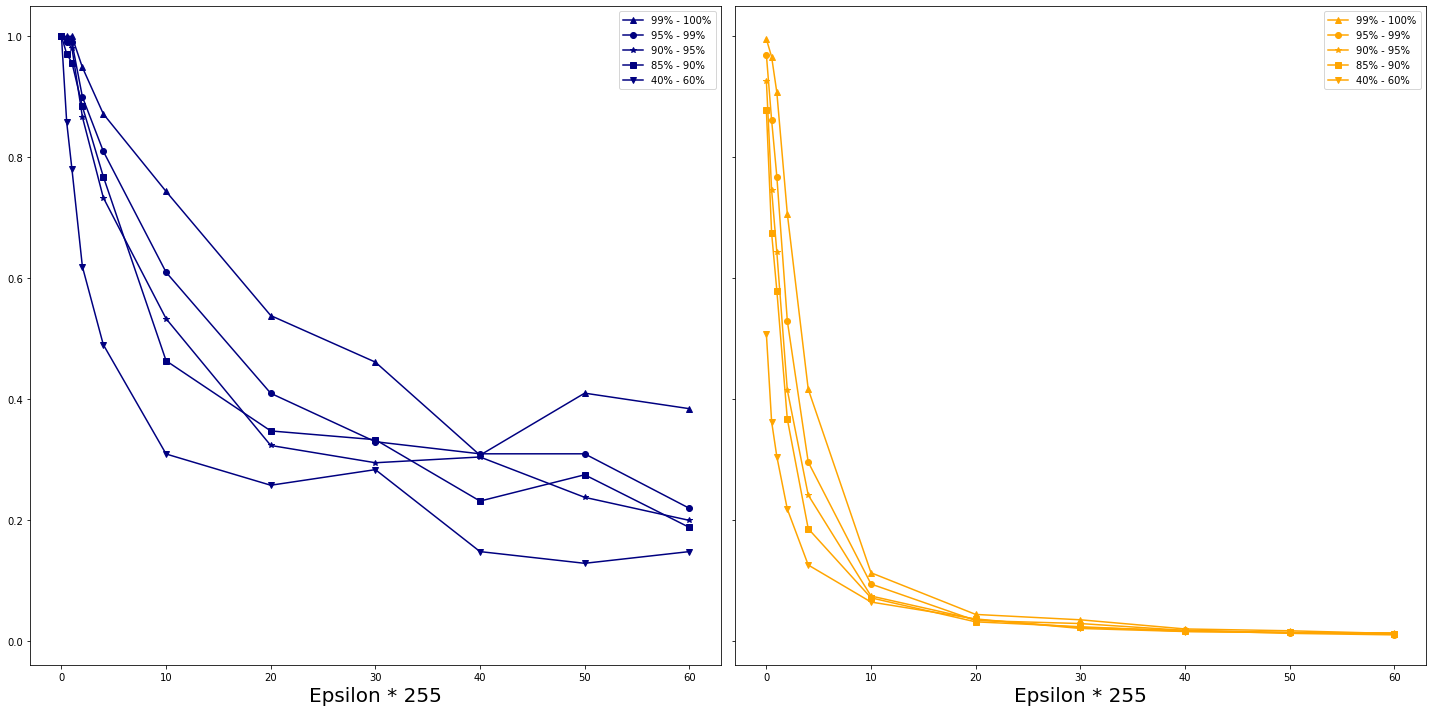

In [4]:
### PLOT 1

# Load data
result_99 = pd.read_csv("results/ILLM/ILLM-Conf99.csv")
result_95 = pd.read_csv("results/ILLM/ILLM-Conf95.csv")
result_90 = pd.read_csv("results/ILLM/ILLM-Conf90.csv")
result_85 = pd.read_csv("results/ILLM/ILLM-Conf85.csv") 
result_40 = pd.read_csv("results/ILLM/ILLM-Conf40.csv")

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

## Top left: Accuracies
axs[0].plot(result_99["Epsilon_255"], result_99["Accuracy Top 1"], "-^", color='navy', label='99% - 100%')
axs[0].plot(result_95["Epsilon_255"], result_95["Accuracy Top 1"], "-o", color='navy', label='95% - 99%')
axs[0].plot(result_90["Epsilon_255"], result_90["Accuracy Top 1"], "-*", color='navy', label='90% - 95%')
axs[0].plot(result_85["Epsilon_255"], result_85["Accuracy Top 1"], "-s", color='navy', label='85% - 90%')
axs[0].plot(result_40["Epsilon_255"], result_40["Accuracy Top 1"], "-v", color='navy', label='40% - 60%')
axs[0].legend()
axs[0].set_xlabel("Epsilon * 255", fontsize=20)

## Bottom left: Confidences
axs[1].plot(result_99["Epsilon_255"], result_99["Confidence"], "-^", color='orange', label='99% - 100%')
axs[1].plot(result_95["Epsilon_255"], result_95["Confidence"], "-o", color='orange', label='95% - 99%')
axs[1].plot(result_90["Epsilon_255"], result_90["Confidence"], "-*", color='orange', label='90% - 95%')
axs[1].plot(result_85["Epsilon_255"], result_85["Confidence"], "-s", color='orange', label='85% - 90%')
axs[1].plot(result_40["Epsilon_255"], result_40["Confidence"], "-v", color='orange', label='40% - 60%')
axs[1].legend()
axs[1].set_xlabel("Epsilon * 255", fontsize=20)

## Save plot
fig.tight_layout()
fig.savefig("plots/ILLM/Accuracies_Confidences.pdf")
fig.savefig("plots/ILLM/Accuracies_Confidences.png")

### 2.2 Including false initial predictions

We compute attacks with all examples. Since the computational cost is high compared to FGSM we split it up into different intervals of epsilon.

In [ ]:
# Filename: ILLM-all_samples.csv

epsilons = [8/255, 16/255, 32/255, 48/255, 64/255, 96/255, 128/255]

alpha = 1/255 # recommended in paper
filename_ext = "0-128"

top1, top5, conf = all_samples_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, filename_ext)

## 3. Indivdual Images

### 3.1 Confidence and correct/false class over epsilon for individual images

We calculate the adversarial confidences for each case where the initial prediction is successful for different epsilons. This allows us to find examples with e.g. high adversarial confidence for further investigations.

In [ ]:
### RUNNING -> Colab

# All images: Only for correct initial classifiation we compute adversaries.
epsilons = [0, 1/255, 2/255, 4/255, 8/255, 16/255, 32/255]

alpha = 1/255


result = pd.DataFrame()

for epsilon in epsilons:   
    conf = []
    
    num_iterations = int(np.min([np.ceil( (epsilon/alpha) + 4 ), np.ceil( 1.25 * epsilon/alpha ) ]))
    
    for sample in range(1000):
        clear_output(wait=True)
        print("Epsilon " + str(epsilon*255))
        print(sample+1)
        
        conf_adv, acc, _ = single_attack_stats_ILLM(data_loader, mean, std, model, predict, epsilon, alpha, sample, idx_to_name, num_iterations)
        
        if acc == 1:
            conf.append(conf_adv)

        else:
            conf.append(0)

    result["Epsilon " + str(int(epsilon*255))] = conf

result.to_csv("results/ILLM/ILLM-adversarial_confidences_corr_only.csv")

In [ ]:
########## ============= OLD ================ ''''''''''''''''''

In [5]:
def compare_examples_ILLM(alpha, epsilon, idx):
    '''
    Generates an example using ILLM. Prints infos and plots clean and adversarial image side-by-side.
    
    Inputs:
    epsilon -- Hyperparameter for ILLM
    alpha   -- Hyperparameter for ILLM
    idx     -- Index of sample   
    '''
    
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    print("Number of iterations: " + str(num_iterations))
    
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)

    image_adv = apply_ILLM(model, image_clean, target_label, alpha, epsilon, num_iterations=num_iterations)

    ## Predictions
    _, _, _, conf_clean, label_clean = predict(model, image_clean, target_label)
    _, _, _, conf_adv, label_adv = predict(model, image_adv, target_label)

    ## Plot
    plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_label)

### 2.1 Individual Images

Do some cool analysis here. In particularm find one of the examples where a wrong class is predicted with high confidence. Apparently there aren't neccessarily that many in the ImageNet dataset?

Number of iterations: 1
			Clean image	 Adversarial image

Actual class: 		bagel, beigel			bagel, beigel
Predicted class: 	bagel, beigel			Band Aid
Confidence: 		43.62%				19.56%



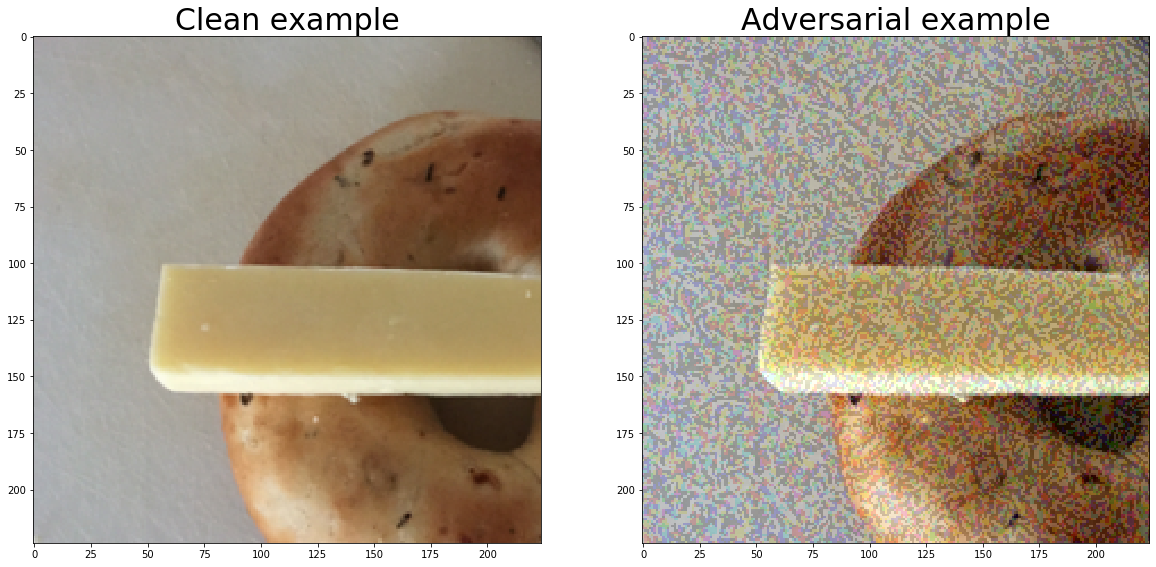

In [6]:
idx = 41
epsilon = 20/255 ## 
alpha = 1 # As in the paper

compare_examples_ILLM(alpha, epsilon, idx)

In [7]:
idx = 49
epsilon = 20/255 ## 
alpha = 1 # As in the paper

compare_examples_ILLM(alpha, epsilon, idx)

Number of iterations: 1


KeyboardInterrupt: 

It can be seen that from a value of around $\epsilon = \frac{10}{255}$ the pertubation becomes visible to the human eye. Note that the model predicts a different class here with a very low confidence.

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

In [ ]:
# Hyperparameters
epsilons = [0, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]
alpha = 1 # As in the paper


# Initialize lists
num_iter = []
accurcy_top1 = []
accurcy_top5 = []
confidence_adversarial = []


for epsilon in epsilons:
   
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    num_iter.append(num_iterations)
    
    acc_sub_adver_top1 = []
    acc_sub_adver_top5 = []
    conf_sub_adver = []
    i = 1
    
    for image_clean, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon*255))
        print("Sample: " + str(i))
        print("Number of iterations: " + str(num_iterations))
        print("Average adv. accuracy: {:.2f}\nAverage adv. confidence: {:.2f}".format(np.mean(acc_sub_adver_top1), np.mean(np.mean(conf_sub_adver) )) )
        
        ## Predict with clean image
        _, corr, _, conf, _ = predict(model, image_clean, label)

        ## Generate adversarial example only if initial prediction was correct
        if corr == 1:
            ## Predict with adversarial image
            image_adversarial = apply_ILLM(model, image_clean, label, alpha, epsilon, num_iterations=num_iterations)
            _, top1, top5, conf, _ = predict(model, image_adversarial, label)
            acc_sub_adver_top1.append(top1)
            acc_sub_adver_top5.append(top5)
            conf_sub_adver.append(conf)
            
        else:
            acc_sub_adver_top1.append(0)
            acc_sub_adver_top5.append(0)
            conf_sub_adver.append(0)
            
        i += 1

    ## Add accuracies and confidences
    accurcy_top1.append(np.mean(acc_sub_adver_top1))
    accurcy_top5.append(np.mean(acc_sub_adver_top5))
    confidence_adversarial.append(np.mean(conf_sub_adver))


## Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Num_Iter"] = num_iter
result["Accuracy Top 1"] = accurcy_top1
result["Accuracy Top 5"] = accurcy_top5
result["Confidence"] = confidence_adversarial
result.to_csv("results/googleNet_ImageNet_ILLM.csv")

## 3. Discussion

In [ ]:
# Load results
result = pd.read_csv("results/googleNet_ImageNet_ILLM.csv")
accurcy_top1 = result["Accuracy Top 1"]
accurcy_top5 = result["Accuracy Top 5"]
confidence_adversarial = result["Confidence"]
epsilon = result["Epsilon_255"]

In [ ]:
# Plot
plt.plot(e, accurcy_top1, "s-", color="navy", label="Top 1")
plt.plot(e, accurcy_top5, "o-", color="navy", label="Top 5")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples from ILLM on ImageNet", fontsize=30)
plt.legend()
plt.show()

#plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_ILLM.pdf")
#plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_ILLM.png")

Some text ...

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*